Task 1

In [13]:
import tensorflow as tf
tf.random.set_seed(1)
import numpy as np
np.random.seed(1)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


import IPython.display 
from PIL import Image
from matplotlib import cm

# simple CNN for MNIST data set
def define_model():
    inputs = tf.keras.Input(shape=(28,28,1),name='inputs')
    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu', name = "Conv2D_1")(inputs)
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu', name = "Conv2D_2")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', name = "Dense_1")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10, name = "Dense_2")(x) # no softmax
    model = keras.Model(inputs,outputs)
    return model


# Load and preprocess training data (MNIST)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
# Subset the data to use only 10,000 samples for training
num_samples = 10000
train_images = train_images[:num_samples]
train_labels = train_labels[:num_samples]
test_images = test_images[:num_samples]
test_labels = test_labels[:num_samples]
# Define and train model
model = define_model()
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),optimizer=keras.optimizers.Adam(),metrics=["accuracy"])
model.fit(train_images,train_labels, validation_data=(test_images,test_labels),batch_size=64, epochs=5)


# Let's look at first test image
x0 = test_images[0:1]
Image.fromarray(np.uint8(255*cm.gray(np.squeeze(x0)))).save('x0.png')
IPython.display.Image('x0.png')

y0 = test_labels[0:1]
print('True class: % i' % np.argmax(y0))
predictions = model.predict(x0)
print('Predictive probabilities:') 
with np.printoptions(precision=10, suppress=True):
    print(np.squeeze(tf.nn.softmax(predictions)))


Epoch 1/5
157/157 [==============================] - 13s 71ms/step - loss: 0.5866 - accuracy: 0.8173 - val_loss: 0.1524 - val_accuracy: 0.9540
Epoch 2/5
157/157 [==============================] - 11s 68ms/step - loss: 0.2185 - accuracy: 0.9378 - val_loss: 0.0970 - val_accuracy: 0.9695
Epoch 3/5
157/157 [==============================] - 11s 71ms/step - loss: 0.1500 - accuracy: 0.9560 - val_loss: 0.0868 - val_accuracy: 0.9733
Epoch 4/5
157/157 [==============================] - 11s 70ms/step - loss: 0.1157 - accuracy: 0.9628 - val_loss: 0.0696 - val_accuracy: 0.9778
Epoch 5/5
157/157 [==============================] - 10s 67ms/step - loss: 0.1047 - accuracy: 0.9692 - val_loss: 0.0644 - val_accuracy: 0.9788
True class:  7
1/1 [==============================] - 0s 103ms/step
Predictive probabilities:
[0.0000000019 0.0000000157 0.0000001817 0.0000004636 0.
 0.0000000001 0.           0.99999905   0.0000000012 0.0000002721]


In [17]:
# Function to define the model with a perturbation layer
def define_attack_model():
    inputs = tf.keras.Input(shape=(28, 28, 1), name='inputs')
    
    # Perturbation layer with 28*28 learnable weights
    perturbation = tf.keras.layers.Conv2D(1, kernel_size=(28, 28), activation='linear', use_bias=False, name="perturbation",
                                        kernel_regularizer=tf.keras.regularizers.l2(1))(inputs)
    
    # Add perturbation to the input
    x = layers.Add(name="addition")([inputs, perturbation])
    
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', name = "Conv2D_1")(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', name = "Conv2D_2")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', name = "Dense_1")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10, name = "Dense_2")(x)  # Linear activation for class scores
    model = keras.Model(inputs, outputs)
    
    return model

# Custom loss function based on Carlini-Wagner criterion
def custom_loss(y_true, y_pred, k=2, lambda_=0.5):

    t = tf.argmax(y_true, axis=1)
    
    f_t = tf.reduce_max(y_pred * y_true, axis=1)  # Score for the true class
    
    max_other_classes = tf.reduce_max(y_pred * (1 - y_true), axis=1)
    
    loss = lambda_ * tf.maximum(max_other_classes - f_t, -k)
    
    return loss


# Define and train the attack model
attack_model = define_attack_model()
for layer in attack_model.layers:
    if not layer.name == "perturbation":
        layer.trainable = False
# setting the weigths
attack_model.get_layer("Conv2D_1").set_weights(model.get_layer("Conv2D_1").get_weights())
attack_model.get_layer("Conv2D_2").set_weights(model.get_layer("Conv2D_2").get_weights())
attack_model.get_layer("Dense_1").set_weights(model.get_layer("Dense_1").get_weights())
attack_model.get_layer("Dense_2").set_weights(model.get_layer("Dense_2").get_weights())
taget_three = np.array([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]])
attack_model.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
attack_model.fit(test_images[:1], taget_three, epochs=100, verbose=False)
perturbation_layer = attack_model.get_layer('perturbation')
# Evaluate the attack model on the first test image
optimized_perturbation = np.array(perturbation_layer.get_weights())
adv_example = test_images[:1] + optimized_perturbation.reshape(1, 28, 28)
# Clip the adversarial example to the range of valid inputs
adv_example = np.clip(adv_example, 0.0, 1.0)

# Verify if the adversarial example is classified as "3"
predictions = model.predict(adv_example)
print('Predicted class:', np.argmax(predictions))
print(f'The Norm of the perturbation is {tf.norm(optimized_perturbation)}')

1/1 [==============================] - 0s 26ms/step
Predicted class: 7
The Norm of the perturbation is 0.3021661043167114


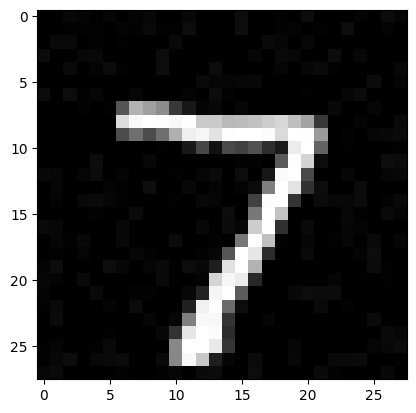

In [15]:
im = Image.fromarray(np.uint8(255*cm.gray(np.squeeze(adv_example))))
plt.imshow(im)

also another way below :)

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train / 255) - 0.5
x_train = tf.reshape(x_train, (-1, 28, 28, 1))
x_test = (x_test / 255) - 0.5
x_test = tf.reshape(x_test, (-1, 28, 28, 1))



In [13]:
class CNN(tf.keras.Model):
    def __init__(self):
        """
        Architecture taken from Carlini and Wagner 2016
        """

        """Hyperparameters"""
        super().__init__()
        # LearningRate0.1
        self.learning_rate = 0.1
        # Momentum0.9
        self.momentum = 0.9
        # DelayRate-
        # Dropout0.5
        self.dropout = 0.5
        # BatchSize128
        self.batch_size = 128
        # Epochs50
        self.epochs = 5

        # visualize loss over time
        self.loss_list = []
        # momentum-based SGD optimizer
        self.optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=self.learning_rate, momentum=self.momentum)


        """Architecture"""
        # Convolution+ReLU3×3×32
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
        # Convolution+ReLU3×3×32
        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
        # MaxPooling2×2
        self.maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        # Convolution+ReLU3×3×64
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
        # Convolution+ReLU3×3×64
        self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
        # MaxPooling2×2
        self.maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        # FullyConnected+ReLU200
        self.fc1 = tf.keras.layers.Dense(units=200, activation='relu')
        # FullyConnected+ReLU200
        self.fc2 = tf.keras.layers.Dense(units=200, activation='relu')
        # Dense(10)
        self.fc3 = tf.keras.layers.Dense(10)
        # Softmax10
        self.softmax = tf.keras.layers.Dense(units=10, activation='softmax')

    def call(self, inputs, is_testing=False):
        """
        Runs a forward pass on the network

        :param inputs: input images
        :param is_testing: if True, we do not apply dropout
        :return: output of the network
        """

        # Convolution+ReLU3×3×32
        x = self.conv1(inputs)
        # Convolution+ReLU3×3×32
        x = self.conv2(x)
        # MaxPooling2×2
        x = self.maxpool1(x)
        # Convolution+ReLU3×3×64
        x = self.conv3(x)
        # Convolution+ReLU3×3×64
        x = self.conv4(x)
        # MaxPooling2×2
        x = self.maxpool2(x)
        # Flatten
        x = tf.keras.layers.Flatten()(x)
        # FullyConnected+ReLU200
        x = self.fc1(x)
        # FullyConnected+ReLU200
        x = self.fc2(x)
        # Dense 10
        x = self.fc3(x)

        return x
    
    def loss(self, labels, logits):
        """
        Computes the loss of the network
        The loss is the cross entropy loss of the network


        :param logits: output of the network
        :param labels: true labels
        :return: loss
        """

        cce = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
        return tf.reduce_mean(cce)


model = CNN()
model.compile(loss=model.loss, optimizer=model.optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=model.batch_size, epochs=model.epochs, shuffle=True)

Epoch 1/5
469/469 [==============================] - 32s 60ms/step - loss: nan - categorical_accuracy: 0.9915
Epoch 2/5
469/469 [==============================] - 29s 63ms/step - loss: nan - categorical_accuracy: 1.0000
Epoch 3/5
469/469 [==============================] - 28s 59ms/step - loss: nan - categorical_accuracy: 1.0000
Epoch 4/5
469/469 [==============================] - 28s 59ms/step - loss: nan - categorical_accuracy: 1.0000
Epoch 5/5
469/469 [==============================] - 28s 60ms/step - loss: nan - categorical_accuracy: 1.0000


In [30]:
from tqdm import tqdm  # shows progress bar during training
import pickle as pk

class L2Attack:

    def __init__(self, model, **kwargs):
        self.model = model  # NOTE the model must return logits
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=kwargs["learning_rate"])
        self.c = kwargs["c"]
        self.num_epochs = kwargs["num_epochs"]
        self.threshold_dist = kwargs["threshold_dist"]
        self.threshold_f = kwargs["threshold_f"]

    def __call__(self, x, target):
        """
        :param x: input image
        :param target: integer corresponding to label target classification
        :return xp: perturbed image that makes the model classify it as the target classification
        """
        # initialize w to be a random image
        x = tf.cast(x, dtype=tf.float32)
        w = tf.Variable(tf.random.normal(tf.shape(x)), dtype=tf.float32)

        # if num_epochs is None, run until the thresholds are reached
        if self.num_epochs is None:
            # run one iteration to get initial values
            dist_loss, f_loss, _ = self.train(x, target, w)
            epoch = 0
            # run until thresholds are reached
            while (dist_loss > self.threshold_dist) or (f_loss > self.threshold_f):
                dist_loss, f_loss, _ = self.train(x, target, w)
                pred = self.model_prediction(w)[0]
                print(f"Epoch {epoch} | dist loss {dist_loss:.3f} | f loss {f_loss:.3f} | model pred {pred}")
                epoch += 1
            # the perturbed image is modified by the tanh function
            xp = 0.5 * (tf.tanh(w) + 1)
            return xp
        else:
            # otherwise, run for num_epochs iterations
            for _ in range(self.num_epochs):
                dist_loss, f_loss, _ = self.train(x, target, w)
                pred = self.model_prediction(w)
            xp = 0.5 * (tf.tanh(w) + 1)
            return xp

    def f(self, xp, target):
        """
        This is the function f that is minimized to ensure that the perturbed image
        attacks the model successfully

        f(x)= max(max{Z(x)i: i!=t} - Z(x)t, −κ)

        Z is the output of the model, Z(x)i is the ith element of Z(x), and t is the target class.
        κ is a constant that controls the confidence of the attack; we set κ = 0 in all experiments.

        :param xp: perturbed image of size [BATCH_SIZE, WIDTH, HEIGHT, NUM_CHANNELS]
        :param target: integer corresponding to label of target classification
        """
        xp = tf.expand_dims(xp, axis=0)
        Z = self.model(xp)
        print(Z)
        Z = tf.reshape(Z, [10])
        Zt = Z[target]
        Z = tf.concat([Z[:target], Z[target+1:]], axis=0)  # i != t
        ret = tf.reduce_max(Z) - Zt
        return tf.maximum(0.0, ret)

    def train(self, x, target, w):
        """
        Performs one iteration of optimizing the objective function
        """
        with tf.GradientTape() as tape:
            delta = 0.5 * (tf.tanh(w) + 1) - x
            dist_loss = tf.square(tf.norm(delta, ord="euclidean"))
            f_loss = self.f(delta + x, target)
            total_loss = dist_loss + self.c * f_loss
        gradients = tape.gradient(total_loss, w)
        self.optimizer.apply_gradients(zip([gradients], [w]))
        return dist_loss, f_loss, total_loss

    def model_prediction(self, w):
        """
        For debugging information. Given w, finds the model's prediction on w.
        """
        xp = 0.5 * (tf.tanh(w) + 1)
        xp = tf.expand_dims(xp, axis=0)
        pred = self.model(xp)
        pred = tf.nn.softmax(pred, axis=1)
        return tf.argmax(pred, axis=1)
    

kwargs = {
        "c": 10,
        "learning_rate": 1e-2,
        "num_epochs": 1,  # If None, attack runs until it reaches the thresholds
        "threshold_dist": 170.0,
        "threshold_f": 0.01
    }
attack = L2Attack(model, **kwargs)
xp = attack(x_test[0], 3)
with open("./output.pk", "wb") as fd:
    pk.dump(xp, fd)

tf.Tensor([[nan nan nan nan nan nan nan nan nan nan]], shape=(1, 10), dtype=float32)


some errors that I did not have time to debugg

Task 2

1/1 [==============================] - 0s 28ms/step
Predicted class: 7
The Norm of the perturbation is 0.5863823294639587


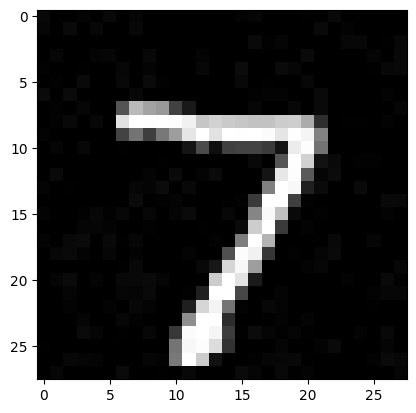

In [12]:
import matplotlib.pyplot as plt

# Define the Hoyer-Square regularizer for element-wise pruning
class HoyerSquareRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight):
        self.weight = weight

    def __call__(self, x):
        sum_abs = tf.reduce_sum(tf.abs(x))**2
        sum_squared = tf.reduce_sum(tf.square(x))
        return self.weight * tf.square(sum_abs) / (sum_squared + tf.keras.backend.epsilon())

    def get_config(self):
        return {'weight': self.weight}

# Define the model with Hoyer-Square regularizer
def define_model_with_regularizer(weight):
    inputs = tf.keras.Input(shape=(28, 28, 1), name='inputs')
    # Perturbation layer with 28*28 learnable weights
    perturbation = tf.keras.layers.Conv2D(1, kernel_size=(28, 28), activation='linear', use_bias=False, name="perturbation",
                                        kernel_regularizer=HoyerSquareRegularizer(weight))(inputs)
    
    # Add perturbation to the input
    x = layers.Add(name="addition")([inputs, perturbation])
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', name="Conv2D_1")(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', name="Conv2D_2")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        name="Dense_1"
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10, name="Dense_2")(x)  # no softmax
    model = tf.keras.Model(inputs, outputs)
    return model

# Load and preprocess training data (MNIST)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)


# Define and train the attack model
# Define and train model with Hoyer-Square regularizer for element-wise pruning
weight = 0.1  # Adjust the weight according to your needs
attack_model = define_model_with_regularizer(weight)
attack_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
for layer in attack_model.layers:
    if not layer.name == "perturbation":
        layer.trainable = False
# setting the weigths
attack_model.get_layer("Conv2D_1").set_weights(model.get_layer("Conv2D_1").get_weights())
attack_model.get_layer("Conv2D_2").set_weights(model.get_layer("Conv2D_2").get_weights())
attack_model.get_layer("Dense_1").set_weights(model.get_layer("Dense_1").get_weights())
attack_model.get_layer("Dense_2").set_weights(model.get_layer("Dense_2").get_weights())
taget_three = np.array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
attack_model.fit(test_images[:1], taget_three, epochs=20, verbose=False)
perturbation_layer = attack_model.get_layer('perturbation')
# Evaluate the attack model on the first test image
optimized_perturbation = np.array(perturbation_layer.get_weights())
adv_example = test_images[:1] + optimized_perturbation.reshape(1, 28, 28)
# Clip the adversarial example to the range of valid inputs
adv_example = np.clip(adv_example, 0.0, 1.0)

# Verify if the adversarial example is classified as "3"
predictions = model.predict(adv_example)
print('Predicted class:', np.argmax(predictions))
print(f'The Norm of the perturbation is {tf.norm(optimized_perturbation)}')

im = Image.fromarray(np.uint8(255*cm.gray(np.squeeze(adv_example))))
plt.imshow(im)